# In this assignment, you will implement the PCA and the k-means algorithm
### 100 points total

In [1]:
# clear all variables
%reset_selective -f a
#import 
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy import loadtxt
import time
from scipy.linalg import eigh

In [2]:
# As we are going to use random values, we need to set a seed
random.seed(200)

## Load data from data.csv file (5 Points)


In [3]:
# Complete the function below to load the data from data.csv. 
# Return X where X is a 1000 by 500 (m=1000 and d=500. d is the number of features)
def load_data(file_name):
    # write your code here
    X = np.loadtxt(file_name, delimiter=',', unpack=True)
    # We know that matrix is transpose, so we need to consider an additional step to get the original values
    X = X.T
    return X

In [4]:
# We can load data
X = load_data("data-1.csv")

In [5]:
# We can check dimensions
X.shape

(1000, 500)

# Before clustering the data, implement PCA to reduce the dimensionality from 500 to 2.

## Preprocess the data (5 Points)

In [6]:
# perform any preprocessing steps in the function below.
def pre_process(X):
    # write your code here. Implementation of z-mean normalization
    for feature in range(X.shape[1]):
      X[:,feature] =  (X[:,feature] - X[:,feature].mean())/X[:,feature].std()
    return X

## Implement PCA to reduce the dimensionality to 2 (30 points if from scratch, 10 points if using a PCA function from a library)

In [7]:
# the below function takes X as (m by 500) and return it as (m by 2) after performing PCA. 
# If implementing from scratch, you can use functions from numpy and numpy.linalg etc
def my_PCA(X):

  # Getting covariance matrix
  cov_mat = np.cov(X, rowvar = False)
  # Getting eigenvalues and eigenvectors
  eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
  # Now, we need to sort the eigenvalues and eigenvalues in descending order as
  # each one is one principal component
  sorted_index = np.argsort(eigen_values)[::-1]
  # Sort eigenvalues and eigenvectors from the most important and go on
  sorted_eigenvalue = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]
  # select the first 2 eigenvectors
  eigenvector_subset = sorted_eigenvectors[:,:2]
  #Transform the data 
  X_2d = np.dot(eigenvector_subset.transpose(),X.transpose()).transpose()
  return X_2d

(1000, 2)


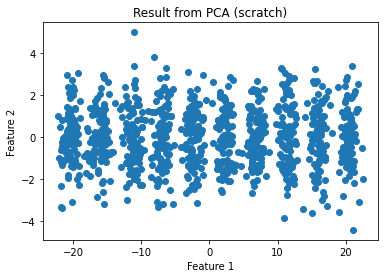

In [8]:
X = pre_process(X)
X_2d = my_PCA(X)
# check out the shape and scatter plot the points
print(X_2d.shape)
plt.scatter(X_2d[:,0],X_2d[:,1]);
plt.title('Result from PCA (scratch)');
plt.xlabel('Feature 1');
plt.ylabel('Feature 2');

# **Comparing with Sklearn PCA algorithm**

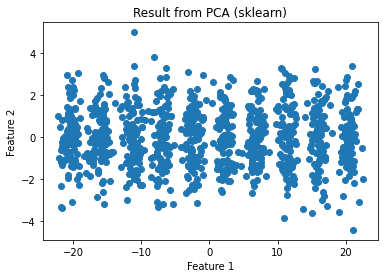

In [9]:
# Checking sklearn

# We load data
X_sklearn = load_data("data-1.csv")
# Do the preprocessing
X_sklearn = pre_process(X_sklearn)

# Load the library for PCA
from sklearn.decomposition import PCA
# Create PCA algorithm. We use svd_solver = full to avoid that sklearn uses only 
# a subset of data to create PCA.
pca = PCA(n_components=2,svd_solver ='full')
# Apply PCA
principalComponents = pca.fit_transform(X_sklearn)
# Show result
plt.scatter(principalComponents[:,0],principalComponents[:,1]);
plt.title('Result from PCA (sklearn)');
plt.xlabel('Feature 1');
plt.ylabel('Feature 2');

Comparing with the PCA algorithm from sklearn, we can see that our PCA model gives us the same solution to sklearn.

# K-means

## Start by implementing a function that randomly initialises centroids (5 points).

In [10]:
#input:
#k: number of centers
#X: the data
# return
# centroids is a k by 2 
def initialise_centroids(X,k):
  # First, we can check which are the boundaries of our data
  min_boundaries, max_boundaries = np.min(X, axis=0), np.max(X, axis=0)
  # Create random centroids
  centroids = [(random.uniform(min_boundaries[0], max_boundaries[0]),random.uniform(min_boundaries[1], max_boundaries[1])) for _ in range(0,k)]
  return centroids

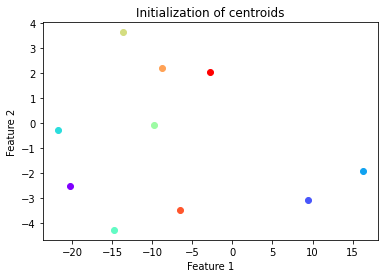

In [11]:
centroids = initialise_centroids(X_2d,10)

# the code below will plot the centroids
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(centroids))))
for c in centroids:
    plt.scatter(c[0], c[1], color=next(colors))
    plt.title('Initialization of centroids');
    plt.xlabel('Feature 1');
    plt.ylabel('Feature 2');

## Implement a function that takes the matrix X and a set of centroids and assigns each point in X to a cluster (5 points)

In [12]:
from scipy.spatial.distance import cdist
#input
# X is a m by 2 point 
# centroids is a k by 2 , the center of k clusters.
#return cluster_assignments is an m by 1 vector. the id of the cluster for each point in X
def assign(X,centroids):
  # First we need to check the distance between each point and our centroids
  distances = cdist(X, centroids ,'euclidean')
  # Centroid with the minimum Distance
  cluster_assignments = np.array([np.argmin(i) for i in distances])   
  # Return points with their centroid values
  return cluster_assignments

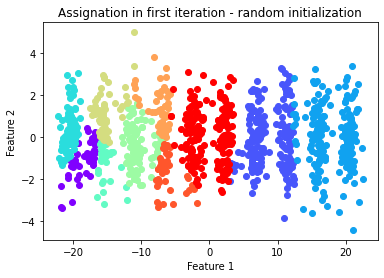

In [13]:
cluster_assignments = assign(X_2d,centroids)

# the code below will plot the points color-coded according to their cluster
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(centroids))))
for k in np.unique(cluster_assignments):
    plt.scatter(X_2d[cluster_assignments==k,0], X_2d[cluster_assignments==k,1], color=next(colors))
    plt.title('Assignation in first iteration - random initialization');
    plt.xlabel('Feature 1');
    plt.ylabel('Feature 2');

## Next, implement a function to compute the value of a cost function given a set of centroids and assignments (10 points)

In [14]:
def cost(X,cluster_assignments,centroids):
  cost_function = 0
  for point in range(0,X.shape[0]):
    cost_function += np.linalg.norm(X[point]-centroids[cluster_assignments[point]])
  cost_function = cost_function/X.shape[0] 
  return cost_function

In [15]:
# the code below tests your functions
k=10
centroids = initialise_centroids(X_2d,k)
cluster_assignments = assign(X_2d,centroids)
c = cost(X_2d,cluster_assignments,centroids)
print(c)

3.123464591648131


## Implement a function to perform the k-means algorithm using the functions you implemented above (40 points, 10 if you use a kmean function from a library)

In [16]:
def My_Kmeans(X,k,num_of_iterations):
 # As random state can have a high influence in our result, an approach is use 
 # a set of random values and check which gives us the min cost
 final_centroids,final_cluster_assignments, cost_function = [],[],[]
 # We try 25 different trials of Kmeans using different initialization
 for trial in range(25):
  check_points_clusters = False
  for iteration in range(num_of_iterations-1):
    # In first iteration, we create random centroids
    while iteration == 0 and check_points_clusters == False:
      # Create random centroids
      centroids = initialise_centroids(X,k)
      # Assign datapoints to centroids
      cluster_assignments = assign(X,centroids)
      # If in assignation a cluster does not have any point, try to 
      # initialize points again
      if len(np.unique(cluster_assignments)) == k:
        check_points_clusters = True
    # calculate the mean of centroids
    for cluster in range(k):
      centroids[cluster] = tuple(np.mean(X[np.where(cluster_assignments == cluster)],axis = 0))
    # Reassign points
    cluster_assignments = assign(X,centroids)
  # Add values of centroids and assignments
  final_centroids.append(centroids.copy())
  final_cluster_assignments.append(cluster_assignments.copy())
  # Add cost function of each trial
  cost_trial = cost(X,cluster_assignments,centroids)
  cost_function.append(cost_trial)
 # Select best values
 cluster_assignments = final_cluster_assignments[cost_function.index(min(cost_function))]
 centroids = final_centroids[cost_function.index(min(cost_function))]
 return cluster_assignments , centroids

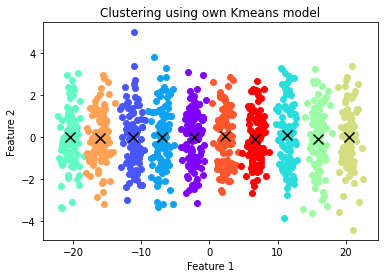

In [17]:
k = 10
centroids = []
cluster_assignments , centroids = My_Kmeans(X_2d,k,1000)

# the code below will plot the points color-coded according to their cluster
colors = iter(plt.cm.rainbow(np.linspace(0, 1, k)))
for k in np.unique(cluster_assignments):
    plt.scatter(X_2d[cluster_assignments==k,0], X_2d[cluster_assignments==k,1], color=next(colors))
    plt.scatter(centroids[k][0],centroids[k][1],marker="x",s=100,c='k')
    plt.title('Clustering using own Kmeans model');
    plt.xlabel('Feature 1');
    plt.ylabel('Feature 2');

# **Comparing with Sklearn Kmeans algorithm**

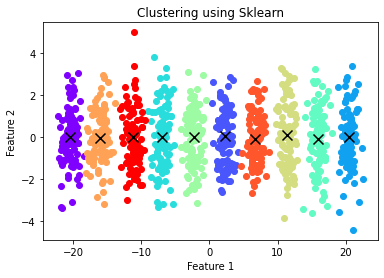

In [18]:
# We can check this process using kmeans from sklearn
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=1).fit(X_2d)
centroids_sklearn = kmeans.cluster_centers_

# Create the same plot
colors = iter(plt.cm.rainbow(np.linspace(0, 1, 10)))
for k in np.unique(kmeans.labels_):
    plt.scatter(X_2d[kmeans.labels_==k,0], X_2d[kmeans.labels_==k,1], color=next(colors))
    plt.scatter(centroids_sklearn[k][0],centroids_sklearn[k][1],marker="x",s=100,c='k')
    plt.title('Clustering using Sklearn');
    plt.xlabel('Feature 1');
    plt.ylabel('Feature 2');

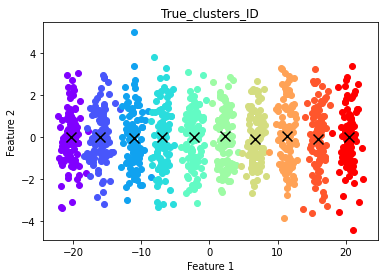

In [19]:
k = 10
cluster_assignments = load_data("True_clusters_IDs.csv")
centroids = []
for idx in range(k):            
    temp_cent = X_2d[cluster_assignments==idx].mean(axis=0)             
    centroids.append(temp_cent)
            
# the code below will plot the points color-coded according to their cluster
colors = iter(plt.cm.rainbow(np.linspace(0, 1, k)))
for k in range(k):
    plt.scatter(X_2d[cluster_assignments==k,0], X_2d[cluster_assignments==k,1], color=next(colors))
    plt.scatter(centroids[k][0],centroids[k][1],marker="x",s=100,c='k')
    plt.title('True_clusters_ID');
    plt.xlabel('Feature 1');
    plt.ylabel('Feature 2');

Checking true clusters, we can see that we get a similar result. We can more ensure about this reviewing centroids values.

In [20]:
# True clusters
centroids_sklearn = [tuple(c) for c in centroids]

# Centroids created by my model
cluster_assignments , centroids_my_model = My_Kmeans(X_2d,k,1000)

# Sort values
centroids_sklearn.sort()
centroids_my_model.sort()


In [21]:
# Print centroids created by our own model
centroids_my_model

[(-20.421041763761036, -0.014982233138187416),
 (-15.873210401232297, 0.02883528930496895),
 (-9.036750302300996, -0.012385514727754307),
 (-2.4850156355312927, 0.011812052400784456),
 (2.279084708911006, 0.05914859803573159),
 (6.751237451777634, -0.09589256455535707),
 (11.41654849733252, 0.09307322800194404),
 (16.005911731085746, -0.05715347939881409),
 (20.50587503108333, -0.0008884717515785621)]

In [22]:
# Print centroids given by sklearn
centroids_sklearn

[(-20.4153246777019, -0.0031297608526022523),
 (-16.028031570092892, 0.010132251365782696),
 (-11.169104931587492, -0.012457923435086735),
 (-6.9173922685923, 0.005531807107750076),
 (-2.337151228760108, 0.004088623484276683),
 (2.279084708911006, 0.05914859803573159),
 (6.731024059776709, -0.08994390332752168),
 (11.390108778877895, 0.08523490884853563),
 (15.985274098669528, -0.059917106980817605),
 (20.481513030499574, 0.0013125057539526174)]

We can see that there are minimal differences between our model and the model created by Sklearn. This may be due that Sklearn algorithm uses a special condition to find centroids.

# **Kmeans dynamic plot**

In [23]:
# Create a new function, but in this case output includes an history of centroids
def My_Kmeans_history(X,k,num_of_iterations):
 # As random state can have a high influence in our result, an approach is use 
 # a set of random values and check which gives us the min cost
 final_centroids,final_cluster_assignments, history_centroids,cost_function = [],[],[],[]
 # We try 25 different trials of Kmeans using different initialization
 for trial in range(25):
  history_centroids_trial = []
  check_points_clusters = False
  for iteration in range(num_of_iterations-1):
    # In first iteration, we create random centroids
    while iteration == 0 and check_points_clusters == False:
      # Create random centroids
      centroids = initialise_centroids(X,k)
      # Assign datapoints to centroids
      cluster_assignments = assign(X,centroids)
      # If in assignation a cluster does not have any point, try to 
      # initialize points again
      if len(np.unique(cluster_assignments)) == k:
        check_points_clusters = True
    history_centroids_trial.append(centroids.copy())
    # calculate the mean of centroids
    for cluster in range(k):
      centroids[cluster] = tuple(np.mean(X[np.where(cluster_assignments == cluster)],axis = 0))
    # Reassign points
    cluster_assignments = assign(X,centroids)
  # Add final centroid point
  history_centroids_trial.append(centroids.copy())
  # Add values of centroids and assignments
  final_centroids.append(centroids.copy())
  final_cluster_assignments.append(cluster_assignments.copy())
  history_centroids.append(history_centroids_trial)
  # Add cost function of each trial
  cost_trial = cost(X,cluster_assignments,centroids)
  cost_function.append(cost_trial)
 # Select best values
 cluster_assignments = final_cluster_assignments[cost_function.index(min(cost_function))]
 centroids = final_centroids[cost_function.index(min(cost_function))]
 history_best_model = history_centroids[cost_function.index(min(cost_function))]
 return cluster_assignments , centroids, history_best_model

# Run model
k = 10
centroids = []
cluster_assignments , centroids, history_best_model = My_Kmeans_history(X_2d,k,1000)

In [24]:
# Include some special libraries to create animation
from matplotlib import animation, rc
from matplotlib.colors import ListedColormap

In [25]:
# Create animation
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])
rc('animation', html='html5')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)

def plot(i, axes = [-25, 25, -5, 5]):
    ax.clear()
    ax.scatter(X_2d[:,0], X_2d[:,1], color = 'lightblue')     
    for k in range(10):
      ax.scatter(history_best_model[i][k][0],history_best_model[i][k][1],marker="x",s=100,c='k')
    tit = ax.set_title(f"Iteration {i+1} - Kmeans clustering process", fontsize=14)
    ax.set_xlabel("Feature 1", fontsize=14)
    ax.set_ylabel("Feature 2", fontsize=14)
    ax.axis(axes)
    return ax

anim = animation.FuncAnimation(fig, plot, frames=30, interval=500)
plt.close()
anim

We can see that during the first 10 or 20 iterations, our model converges to the expected solution. Based on this, we can add an **early_stop** parameter, to indicate to our algorithm that if cost function does not improve in a next iteration, it stopped to run. 

If plot does not show up, restart runtime and run all.

# **References**

* **Gopinath Rebala, Ajay Ravi & Sanjay Churiwala**. 2019. An Introduction to Machine Learning. Springer Cham.

* Principal Component Analysis from Scratch in Python. https://www.askpython.com/python/examples/principal-component-analysis

* Definitive Guide to K-Means Clustering with Scikit-Learn. https://stackabuse.com/k-means-clustering-with-scikit-learn/